# Location assessment
*This notebook illustrates methods to assess the geography of a distribution network*  
*Use the virtual environment logproj_distribution.yml to run this notebook.*
***
Alessandro Tufano 2020

### Import packages

In [1]:
#suppress warnings
import warnings
warnings.filterwarnings("ignore")

# %% append functions path
import sys; sys.path.insert(0, '..') #add the above level with the package

#import utilities
from logproj.utilities import creaCartella

import numpy as np
import plotly
import plotly.express as px

from IPython.display import display, HTML

### Set data fields

In [2]:
#set project name
dbName='TOY_DATA'

In [3]:
#columns node data
latCol='LATITUDE'
lonCol='LONGITUDE'
colore='CLIENT_TYPE'
descrCol='NODECODE'
node_id= 'NODECODE'

In [4]:
#columns plant data
latCol_plant='LATITUDE'
lonCol_plant='LONGITUDE'
plantListName='listClient'
plant_id= 'NODECODE'

In [5]:
#columns movements data
movementColumns= {
           'timevariable':'TIMESTAMP_IN', #colonna obbligatoria con i timestamp per ogni movimento
           'capacityField':'QUANTITY', #colonna obblicatoria che identifica la quantita' movimentata
           
            'vehiclefield':'VEHICLE_CODE', #colonna che identifica il veicolo utilizzato
           
            'terminalfieldFrom':'LOADING_NODE', #colonna che identifica il nodo di carico
            'terminalfieldto':'DISCHARGING_NODE', #colonna che identifica il nodo di scarico
    
            'latitude_from': 'LOADING_NODE_LATITUDE', #latitude of the discharging node
            'longitude_from' : 'LOADING_NODE_LONGITUDE', #latitude of the discharging node
    
            'latitude_to' : 'DISCHARGING_LATITUDE', #latitude of the discharging node
            'longitude_to' : 'DISCHARGING_LONGITUDE' #latitude of the discharging node
    
    
    
    
  
           }

timeColumns = {'loadingpta':'PTA_FROM',
               'loadingptd':'PTD_FROM', 
               'dischargingpta':'PTA_TO', 
               'dischargingptd':'PTD_TO', 
               'loadingata':'ATA_FROM', 
               'loadingatd':'ATD_FROM', 
               'dischargingata':'ATA_TO', 
               'dischargingatd':'ATD_TO'
               }

### Set folder hierarchy

In [6]:
pathResults = 'C:\\Users\\aletu\\desktop'
_, root_path = creaCartella(pathResults,f"{dbName}_results")
_, path_results = creaCartella(root_path,f"P8_networkAssessment")

Cartella TOY_DATA_results già esistente
Cartella P8_networkAssessment già esistente


### Import data

In [7]:
# %% import data
from logproj.data_generator_distribution import generateDistributionData

#random generation of distribution data
D_table, _, D_plant, D_mov = generateDistributionData()
D_plant['_id'] =D_plant['NODECODE'] #set the id of the plant 

In [8]:
#print D_table (nodes)
display(HTML(D_table.to_html()))

In [9]:
#print D_plant
display(HTML(D_plant.to_html()))

In [10]:
#print D_mov
print(f"Table with {len(D_mov)} movements")
display(HTML(D_mov.to_html()))


Table with 100 movements


### Supply chain network nodetype

In [11]:

D_table=D_table.dropna(subset=[latCol,lonCol])
D_table[colore]=D_table[colore].astype(str)

fig = px.scatter_mapbox(D_table, lat=latCol, lon=lonCol,
                     hover_name=descrCol, size="SIZE",color=colore)
fig.update_layout(mapbox_style="open-street-map")
plotly.offline.plot(fig, filename = f"{path_results}//supplyChainNodeType.html", auto_open=False)
fig.show()


### Supply chain network nodes

In [12]:
fig = px.scatter_mapbox(D_table, lat=latCol, lon=lonCol,
                     hover_name=descrCol, size="SIZE")
fig.update_layout(mapbox_style="open-street-map")
plotly.offline.plot(fig, filename = f"{path_results}//supplyChainNodes.html", auto_open=False)
fig.show()

### Supply chain covering

In [13]:
#the map use the same color for the nodes served by the same plant
D_table['SERVICE_NODE']=np.nan


for index, row in D_table.iterrows():
    for plant in D_plant[plant_id]:
    
        if row[node_id] in D_plant[D_plant[plant_id]==plant][plantListName].iloc[0]:
            D_table['SERVICE_NODE'].loc[index]=plant
    
D_table['SERVICE_NODE']=D_table['SERVICE_NODE'].astype(str)    
fig = px.scatter_mapbox(D_table, lat=latCol_plant, lon=lonCol_plant,
                     hover_name=descrCol, size="SIZE",color='SERVICE_NODE')
fig.update_layout(mapbox_style="open-street-map")
plotly.offline.plot(fig, filename = f"{path_results}//supplyChainCovering.html", auto_open=False)   
fig.show()

C:\Users\aletu\.conda\envs\ox\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Supply chain centers of mass

In [14]:
D_plant['lon_ave'] = D_plant['lat_ave']=np.nan
for index, row in D_plant.iterrows():
    
    D_table_plant = D_table[D_table['SERVICE_NODE']==row[node_id]]
    lon_ave = np.nanmean(D_table_plant[lonCol_plant])
    lat_ave = np.nanmean(D_table_plant[latCol_plant])
    D_plant['lon_ave'].loc[index] = lon_ave
    D_plant['lat_ave'].loc[index] = lat_ave

#plot the existent plant
fig = px.scatter_mapbox(D_plant, lat=latCol_plant, lon=lonCol_plant, color=latCol_plant)

#plot the centers of mass
fig = fig.add_trace(px.scatter_mapbox(D_plant, lat='lat_ave', lon='lon_ave',color=plant_id).data[0])
fig.update_layout(mapbox_style="open-street-map")
plotly.offline.plot(fig, filename = f"{path_results}//supplyChainCentersOfMass.html", auto_open=False)   
fig.show()


In [15]:
#interactive centers of mass plot
import plotly.graph_objects as go
fig = go.Figure(go.Scattermapbox(
        lat=D_plant[latCol_plant],
        lon=D_plant[lonCol_plant],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14,
            color = 'blue'
        ),
        text='ASIS',
        name='Plant AS IS Location'
    ))

fig.add_trace(
        go.Scattermapbox(
        lat=D_plant['lat_ave'],
        lon=D_plant['lon_ave'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14,
            color = 'red',
            #symbol = 'cross'
        ),
        text="CENTER OF MASS",
        name='Plant Center of Mass'
        )
    )

fig.add_trace(px.scatter_mapbox(D_table, lat=latCol, lon=lonCol,
                     hover_name=descrCol, color='SERVICE_NODE').data[0])
fig.update_layout(mapbox_style="open-street-map")
fig.show()
plotly.offline.plot(fig, filename = f"{path_results}//supplyChainCentersOfMass.html", auto_open=False)  

'C:\\Users\\aletu\\desktop\\TOY_DATA_results\\P8_networkAssessment//supplyChainCentersOfMass.html'

### Import road graph

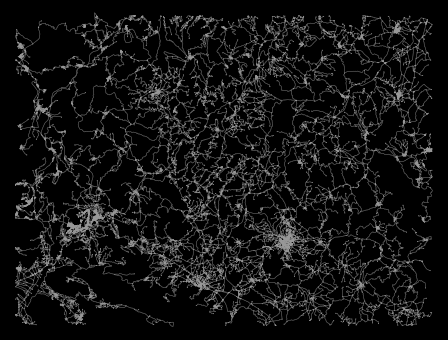

In [16]:
#Import graph package
import osmnx as ox
from logproj.P6_placementProblem.distribution_graph_definition import import_graph_drive

G, _ = import_graph_drive(D_table,latCol,lonCol,D_plant, latCol_plant, lonCol_plant,cleanOutliers=False)

# rappresento il grafo
fig, ax = ox.plot_graph(G, bgcolor='k', 
                        node_size=1, node_color='#999999', node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=0.5, edge_alpha=1)

#salvo figura del grafo
fig.savefig(f"{path_results}//road_network.png")


### Analyse network rays

In [17]:
from logproj.P8_performanceAssessment.network_graph_analysis import networkRaysPlot
_, currentPath = creaCartella(path_results,f"Network Graph Assessment")
outputfigures, outputCoverages = networkRaysPlot(D_mov=D_mov, 
                                timecol=movementColumns['timevariable'],
                                lonCol_to=movementColumns['longitude_to'], 
                                latCol_to=movementColumns['latitude_to'], 
                                lonCol_from=movementColumns['longitude_from'], 
                                latCol_from=movementColumns['latitude_from'], 
                                G=G,
                                capacityField=movementColumns['capacityField'],
                                sampleInterval='year')

for key in outputfigures.keys():
        outputfigures[key].savefig(currentPath+f"\\{key}.png")
        outputfigures[key]
for key in outputCoverages.keys():
        outputCoverages[key].to_excel(currentPath+f"\\{key}.xlsx")
#check the output folder to see the resulting figure

Cartella Network Graph Assessment già esistente


..\logproj\P8_performanceAssessment\network_graph_analysis.py:122: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



### Analyse network arcs

**** DEFINISCO D MOV IN/OUT ****
**** DEFINISCO ROUTE  ****
**** RICOSTRUZIONE DEGLI INVENTARI  ****
==RICOSTRUISCO INVENTARIO VIAGGIO TRUCK 1, con 180 MOVIMENTI


C:\Users\aletu\.conda\envs\ox\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



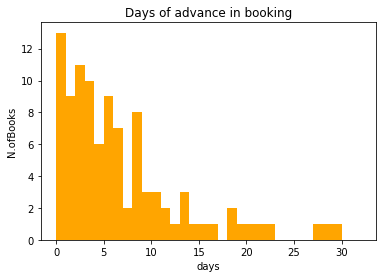

In [18]:
# generate arc flow data using theV EHICLE STATISTICS
from logproj.P8_performanceAssessment.vehicle_assessment import D_voyageStatistics
         
        
#define arc table
D_route,  D_arcs_route, D_coverages  = D_voyageStatistics(D_mov,
                                    timefield=movementColumns['timevariable'],
                                    locfrom = movementColumns['terminalfieldFrom'],
                                    locto= movementColumns['terminalfieldto'],
                                    timeColumns = timeColumns,
                                    capacityField=movementColumns['capacityField'],
                                    voyagefield =movementColumns['vehiclefield'],
                                    censoredData=False, #use complete data   
                                    actual='ACTUAL') #use actual data           

In [19]:
#print arc flow table
display(HTML(D_arcs_route.to_html()))           

..\logproj\P8_performanceAssessment\network_graph_analysis.py:148: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

..\logproj\P8_performanceAssessment\network_graph_analysis.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

..\logproj\P8_performanceAssessment\network_graph_analysis.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

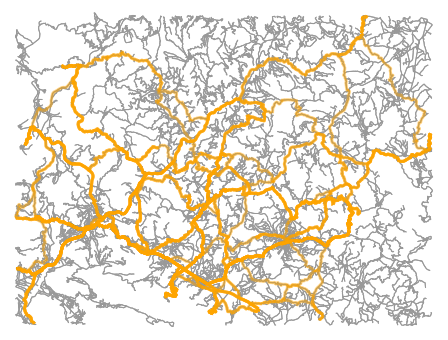

In [20]:
#plot travelled arcs on the graph
from logproj.P8_performanceAssessment.network_graph_analysis import networkRoadsRoutePlot
if len(D_arcs_route)>0:
    outputfigures = networkRoadsRoutePlot(D_arcs=D_arcs_route,
                                          lonCol_from = 'DISCHARGING_LONGITUDE_from', 
                                          latCol_from ='DISCHARGING_LATITUDE_from', 
                                          latCol_to ='DISCHARGING_LATITUDE_to',
                                          lonCol_to = 'DISCHARGING_LONGITUDE_to', 
                                          G=G)
    for key in outputfigures.keys():
            outputfigures[key].savefig(currentPath+f"\\{key}.png")